## This script makes figures using the output of motor_pipeline.ipynb

### Import Packages

In [27]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

### Define Paths and Variables

In [20]:
grp_df = pd.read_csv('grp_df_3T_012624.csv')
diag_df = pd.read_csv('diag_df_3T_012624.csv')

# Choose what to analyse
networks = ["SomMot"] 
CESTnetworks = ["avgCEST_SomMot", "ctCEST_SomMot"]
CNB_scores = ["tap_tot"]
CNB_valids = ["tap_valid"] 
diag_scores = ["hstatus"]
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]

### Data Trimming

In [21]:
# Standardize groups and keep only PSD or healthy
grp_df['hstatus'] = grp_df['hstatus'].replace('NC', 'HC')
grp_df['hstatus'] = grp_df['hstatus'].replace('PROR', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('PRO', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('S', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('O', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('Unknown', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('MDD', 'Other')

grp_df = grp_df.dropna(subset=['SomMot', 'avgCEST_SomMot', 'hstatus']) 
value_counts = grp_df['hstatus'].value_counts() 
print(value_counts)

#Exclude tap-tot outliers, which are >2.5 standard deviations from the mean.
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]
grp_df = grp_df[grp_df['hstatus'] != 'Other']
value_counts = grp_df['hstatus'].value_counts() 
print(value_counts)

hstatus
PSY      22
HC       17
Other     4
Name: count, dtype: int64
hstatus
PSY    21
HC     16
Name: count, dtype: int64


### Subjects Excluded:

#### Only 4 people in other group. Given reviews on meta-analysis and small "Other" sample, exclude from present analysis.
#### Exclude outliers for taptot (i.e. >2.5 sd from sample mean of 106)
#### 
#### 



### Demographics

In [22]:
age = grp_df.groupby("hstatus").agg(
    Age_avg = ("age", "mean"),
    Age_std = ("age", "std"),
)
sex_counts = grp_df.groupby('hstatus')['sex'].value_counts()    
print(sex_counts)
race_counts = grp_df.groupby('hstatus')['race'].value_counts()    
print(race_counts)

# Table 1 of manuscript should have:
# Average age (SD)
# Male/female
# Racial demographics
# Psychosis spectrum severity score?
# Medications?
# Comorbidities

hstatus  sex
HC       1.0     8
         2.0     8
PSY      2.0    15
         1.0     6
Name: count, dtype: int64
hstatus  race
HC       1.0      9
         2.0      6
         5.0      1
PSY      2.0     12
         1.0      6
         5.0      3
Name: count, dtype: int64


### Histograms

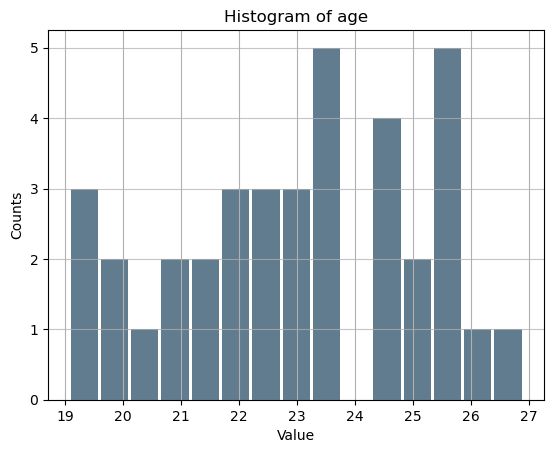

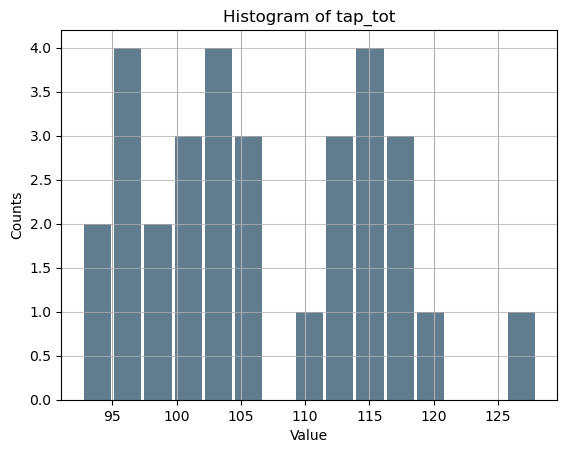

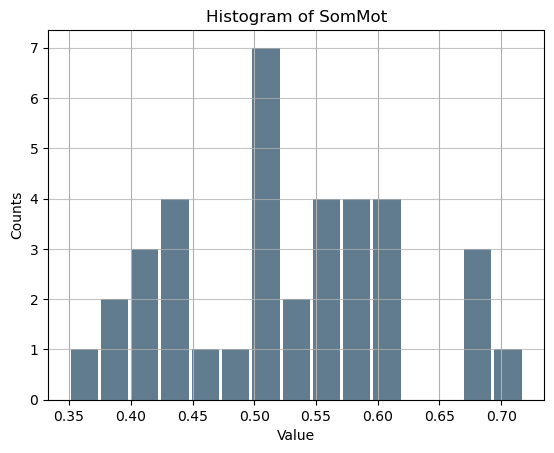

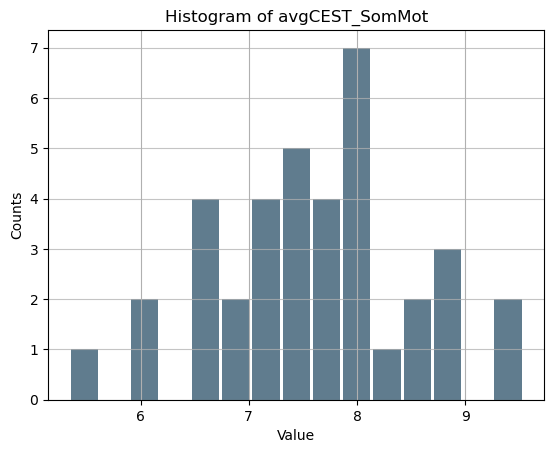

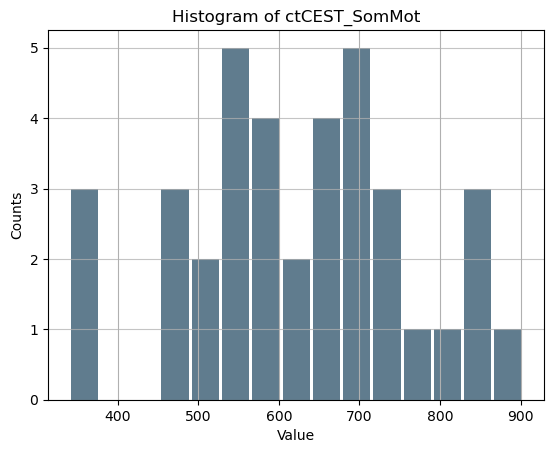

106.89246741935483
8.872087718677406


In [23]:
# Histograms
vars = ['age', 'tap_tot', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot']     
for var in vars:
    plt.figure()
    input = pd.Series(grp_df[var])
    input.plot.hist(grid=True, bins=15, rwidth=0.9, color='#607c8e')
    plt.title('Histogram of ' + var)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

print(grp_df['tap_tot'].mean())
print(grp_df['tap_tot'].std())

### Make Figures

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


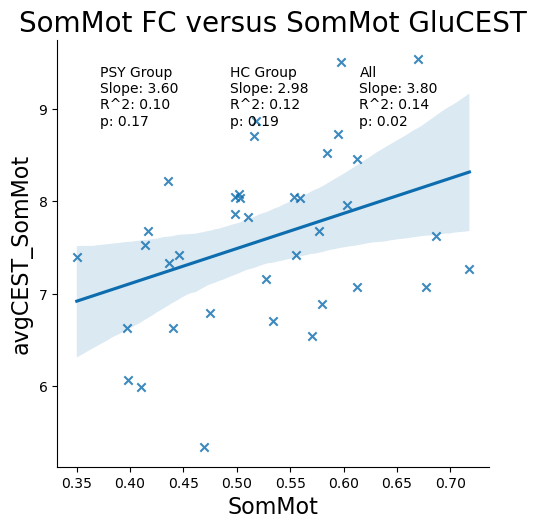

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


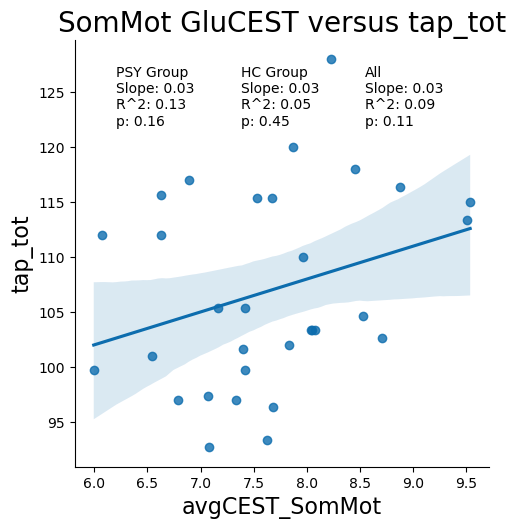

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


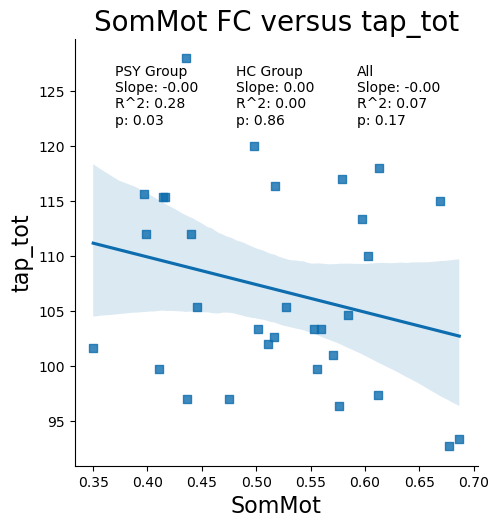

  hstatus_  avgCEST_SomMot_mean  avgCEST_SomMot_std  SomMot_mean  SomMot_std
0       HC             7.939347            0.901972     0.546046    0.105422
1      PSY             7.319434            0.869048     0.509880    0.074961


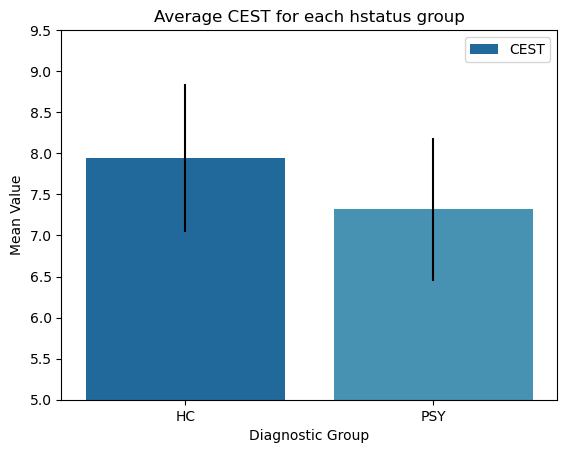

CEST t test: t=-2.114886879031197, p=0.04163228881599582


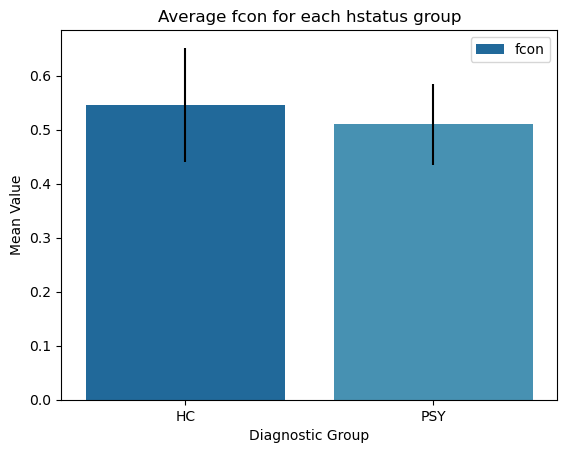

FC t test: t=-1.2204612383889522, p=0.23044927065415896


In [32]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

#Exclude tap-tot outliers (>2.5 sd from sample mean of 106 (sd 11)
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]


# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus'])
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='hstatus', 
    if network == "SalVentAttn":
        plt.xlabel("SN", fontsize=16)
        plt.ylabel("avgCEST_SN", fontsize=16)
        plt.title('SN FC versus SN GluCEST', fontsize = 20)
    else:
        plt.xlabel(network, fontsize=16)
        plt.ylabel(cestcol, fontsize=16)
        plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', network], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
#     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', network], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'hstatus'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("avgCEST_SN", fontsize=16)
            plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
        else: 
            plt.xlabel(cestcol, fontsize=16)
            plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()    

        #graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, network, 'hstatus'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.title('SN FC versus ' + CNB_score, fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', network])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', network])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()  

    # Make bar graph comparing diagnostic groups
    avg_df = grp_df.groupby('hstatus').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
    # Flatten the multi-level columns
    avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
    print(avg_df)

    
    # Plot CEST bar graph with error bars
    sns.barplot(x='hstatus_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.ylim(5, 9.5)
    plt.title('Average CEST for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'avgCEST_SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'avgCEST_SomMot'])
    print('CEST t test: t=' + str(t_statistic) + ', p=' + str(p_value))
    # Plot fcon bar graph with error bars
    sns.barplot(x='hstatus_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.title('Average fcon for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'SomMot'])
    print('FC t test: t=' + str(t_statistic) + ', p=' + str(p_value))


### Multiple Linear Regression




SomMot & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.004
Date:                Fri, 26 Jan 2024   Prob (F-statistic):             0.0139
Time:                        20:58:04   Log-Likelihood:                -106.41
No. Observations:                  31   AIC:                             218.8
Df Residuals:                      28   BIC:                             223.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         92.654

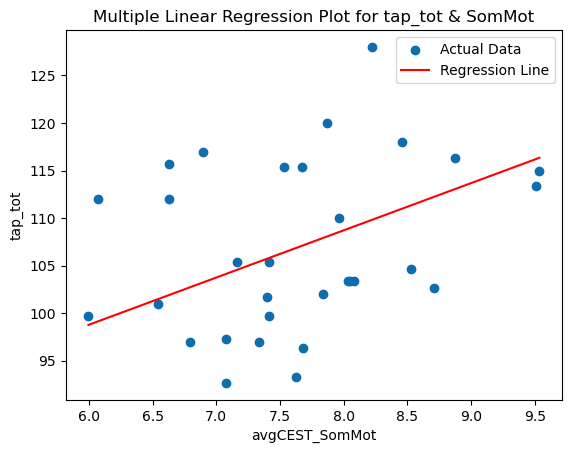

In [33]:

colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

anova_tables = []
# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    # Create a linear regression model for fcon
   # color = colors.loc[colors['Network'] == network, 'Color'].values[0]
   # sns.set_palette(color)

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        # Define formula and model
        formula = f'{CNB_score} ~ {cestcol} + {network}'
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('\n\n\n' + network + ' & ' + CNB_score) 
        print(model.summary())

        # Plotting the regression line
        fig, ax = plt.subplots()
        ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                               network: np.mean(graph_df[network])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
        ax.set_xlabel(cestcol)
        ax.set_ylabel(CNB_score)
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
        ax.legend()
        plt.show()

### 3D Plot Troubleshooting

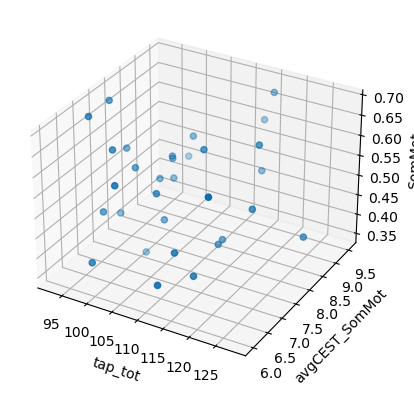

In [38]:
# BBS
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
        ax.set_xlabel(CNB_score)
        ax.set_ylabel(cestcol)
        ax.set_zlabel(network)
        plt.show()

In [ ]:
###Save Output

In [ ]:
!jupyter nbconvert --to html motor_figures.ipynb --output motor_figures_3T.html